# Example: Human segmentation with TransUnet and transfer learning from ImageNet-trained VGG16 model

In [19]:
import os
import cv2
from skimage.io import imread
import numpy as np
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from sklearn.metrics import f1_score, jaccard_score

from keras_unet_collection import models, utils

In [28]:
# !pip install tensorflow-gpu==2.5.0

In [5]:
#!pip install keras-unet-collection

  Using cached keras_unet_collection-0.1.11-py3-none-any.whl (67 kB)


In [54]:
!pip install -U --pre segmentation-models --user

In [12]:
!pip install -U albumentations>=0.3.0 --user 

This example requires `keras-unet-collection`:
```
pip install keras-unet-collection
```

In [13]:
print(tf.__version__)

2.5.0


In [14]:
# the indicator of a fresh run
FIRST_TIME_RUNNING = False

# user-specified working directory
FILE_PATH = 'dataset/'
FILE_PATH_LABEL = 'dataset/'

## The Monuseg dataset

The dataset for this challenge was obtained by carefully annotating tissue images of several patients with tumors of different organs and who were diagnosed at multiple hospitals. This dataset was created by downloading H&E stained tissue images captured at 40x magnification from TCGA archive. 

H&E staining is a routine protocol to enhance the contrast of a tissue section and is commonly used for tumor assessment (grading, staging, etc.). 

Given the diversity of nuclei appearances across multiple organs and patients, and the richness of staining protocols adopted at multiple hospitals, the training dataset will enable the development of robust and generalizable nuclei segmentation techniques that will work right out of the box.

In [15]:
# train files path
path_train_img = FILE_PATH + 'train folder/img/'
path_train_mask = FILE_PATH_LABEL + 'train folder/mask/'

# validation file path
path_valid_img = FILE_PATH + 'validation folder/img/'
path_valid_mask = FILE_PATH_LABEL + 'validation folder/mask/'

# test files path
path_test_img = FILE_PATH + 'test folder/img/'
path_test_mask = FILE_PATH_LABEL + 'test folder/mask/'

# predict files path
path_predict_mask = FILE_PATH + 'predict folder/'


In [16]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled', 'cell']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        mask = np.zeros((128, 128), dtype=np.bool)
        mask_read = imread(self.masks_fps[i])
        mask = mask_read.astype(bool)
        mask = np.expand_dims(mask, axis=-1).astype(int)
        
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

C:\Users\MCSP_Lab\AppData\Local\Temp/ipykernel_22788/3536076542.py:67: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((128, 128), dtype=np.bool)


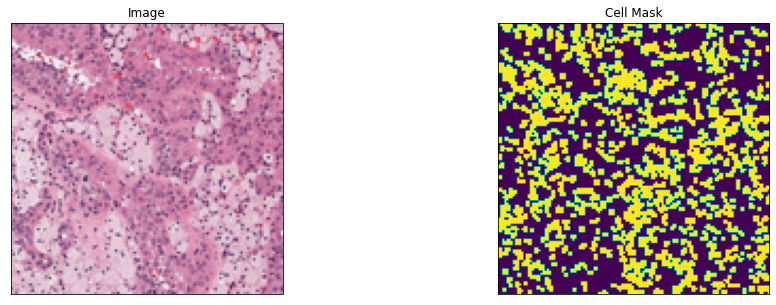

In [20]:

# Lets look at data we have
dataset = Dataset(path_train_img, path_train_mask, classes=['cell'])

image, mask = dataset[5] # get some sample

visualize(
    image=image, 
    cell_mask=mask[..., 0].squeeze(),
   # background_mask=mask[..., 1].squeeze(),
)

### Augmentations


Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.

In [21]:
import albumentations as A

In [41]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=128, min_width=128, always_apply=True, border_mode=0),
        A.RandomCrop(height=128, width=128, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(384, 480)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

C:\Users\MCSP_Lab\AppData\Local\Temp/ipykernel_22788/3536076542.py:67: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((128, 128), dtype=np.bool)


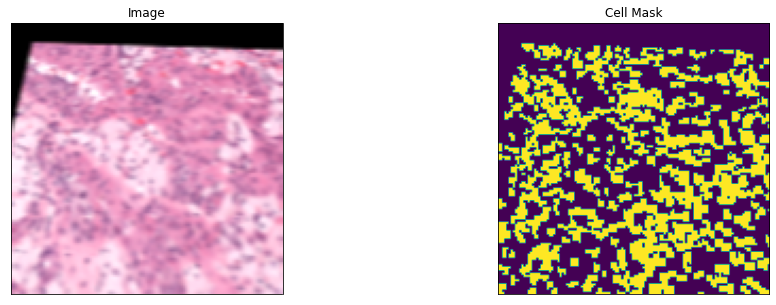

In [42]:

# Lets look at data we have
dataset = Dataset(path_train_img, path_train_mask, classes=['cell'], augmentation=get_training_augmentation())

image, mask = dataset[5] # get some sample

visualize(
    image=image, 
    cell_mask=mask[..., 0].squeeze(),
   # background_mask=mask[..., 1].squeeze(),
)

train_input_names = np.array(sorted(glob(path_train_img+'*.png')))
train_label_names = np.array(sorted(glob(path_train_mask+'*.png')))

In [16]:
test_input_names = np.array(sorted(glob(path_test_img+'*.png')))
test_label_names = np.array(sorted(glob(path_test_mask+'*.png')))

In [17]:
# get valid files name
valid_input_names = np.array(sorted(glob(path_valid_img+'*.png')))
valid_label_names = np.array(sorted(glob(path_valid_mask+'*.png')))

In [45]:
# get predict file names
predict_label_names = np.array(sorted(glob(path_predict_mask+'*.png')))

### Exploratory data analysis

In [19]:
def ax_decorate_box(ax):
    [j.set_linewidth(0) for j in ax.spines.values()]
    ax.tick_params(axis="both", which="both", bottom=False, top=False, labelbottom=False, left=False, right=False, labelleft=False)
    return ax

In [20]:
I_MAX = 10   # explore 10 images
input_example = utils.image_to_array(train_input_names[:I_MAX], size=128, channel=3)
label_example = utils.image_to_array(train_label_names[:I_MAX], size=128, channel=1)

Text(0.5, 1.0, 'Segmentation mask')

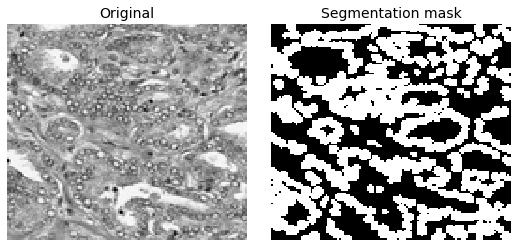

In [21]:
i_example = 2

fig, AX = plt.subplots(1, 2, figsize=(7, 3))
plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0.1)

for ax in AX:
    ax = ax_decorate_box(ax)
AX[0].pcolormesh(np.mean(input_example[i_example, ...], axis=-1), cmap=plt.cm.gray)
AX[1].pcolormesh(label_example[i_example, ..., 0] > 0, cmap=plt.cm.gray)
AX[0].set_title("Original", fontsize=14)
AX[1].set_title("Segmentation mask", fontsize=14)

## Attention U-net with an ImageNet-trained backbone

Attention U-net is applied for this segmentation task. This architecture is modified from the conventionally used U-net by assigning attention gates on each upsampling level. 

Attention gates take upsampled (i.e., decoded) and downsampled (i.e., encoded) tensors as queries and keys, respectively. These queries and keys are mapped to intermediate channel sizes and fed into the additive attention learning. The resulting vector is rescaled by a sigmoid function and multiplied with the downsampled tensor (keys, but here treated as "values" of self-attention). The attention gate output replaces the downsampled tensor and is concatenated with the upsampled tensor.

Based on the amount and complexity of COCO samples, ImageNet-trained VGG16 is applied as an encoder backbone. This transfer learning strategy is expected to improve the segmentation performance based on two reasons: 

 * The ImageNet and COCO containts (somewhat) similar kinds of natural images with a high overlap of data distribution; 

 * The VGG16 architecture is a combination of same-padding convolution and max-pooling kernels, capable of extracting hierarchical features that can be processed by attention gates (ResNet backbone contains zero padding layers and is suboptimal in this case).

The code cell below configures the attention U-net with an ImageNet-trained VGG16 backbone. Hyper-parameters are explained through the Python helper function:

```python
from keras_unet_collection import models

help(models.att_unet_2d)
```

In [65]:

model = models.swin_unet_2d((128, 128, 3), filter_num_begin=64, n_labels=2, depth=4, stack_num_down=2, stack_num_up=2,
                            patch_size=(2, 2), num_heads=[4, 8, 8, 8], window_size=[4, 2, 2, 2], num_mlp=512,
                            output_activation='Softmax', shift_window=True, name='swin_unet')


In [24]:

model = models.swin_unet_2d((128, 128, 3), filter_num_begin=64, n_labels=2, depth=4, stack_num_down=2, stack_num_up=2,
                            patch_size=(2, 2), num_heads=[4, 8, 8, 8], window_size=[4, 2, 2, 2], num_mlp=512,
                            output_activation='Softmax', shift_window=True, name='swin_unet')


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


The second layer of the configured model, i.e., right after an input layer, is expected to be the VGG16 backbone.

In [66]:
model.layers[1].name

'patch_extract_1'

For simplicity, this segmentation model is trained with cross-entropy loss with SGD optimizer and a learning rate of 1E-2.

In [67]:
model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.SGD(lr=1e-2), metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])

## Create Keras metric

## Segmentation model training

In [83]:
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

In [84]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 8
CLASSES = ['cell']
LR = 0.0001
EPOCHS = 40

preprocess_input = sm.get_preprocessing(BACKBONE)

In [80]:

# Dataset for train images
train_dataset = Dataset(
    path_train_img, 
    path_train_mask, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    path_valid_img, 
    path_valid_mask, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 128, 128, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 128, 128, 1)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

C:\Users\MCSP_Lab\AppData\Local\Temp/ipykernel_22788/3536076542.py:67: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((128, 128), dtype=np.bool)


In [81]:
print(len(train_dataloader[0]))

2


C:\Users\MCSP_Lab\AppData\Local\Temp/ipykernel_22788/3536076542.py:67: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((128, 128), dtype=np.bool)


In [82]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/40


C:\Users\MCSP_Lab\AppData\Local\Temp/ipykernel_22788/3536076542.py:67: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((128, 128), dtype=np.bool)


ValueError: in user code:

    C:\Users\MCSP_Lab\anaconda3\envs\SwinUnetPlusPlus\lib\site-packages\tensorflow\python\keras\engine\training.py:855 train_function  *
        return step_function(self, iterator)
    C:\Users\MCSP_Lab\anaconda3\envs\SwinUnetPlusPlus\lib\site-packages\tensorflow\python\keras\engine\training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\MCSP_Lab\anaconda3\envs\SwinUnetPlusPlus\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\MCSP_Lab\anaconda3\envs\SwinUnetPlusPlus\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\MCSP_Lab\anaconda3\envs\SwinUnetPlusPlus\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\MCSP_Lab\anaconda3\envs\SwinUnetPlusPlus\lib\site-packages\tensorflow\python\keras\engine\training.py:838 run_step  **
        outputs = model.train_step(data)
    C:\Users\MCSP_Lab\anaconda3\envs\SwinUnetPlusPlus\lib\site-packages\tensorflow\python\keras\engine\training.py:795 train_step
        y_pred = self(x, training=True)
    C:\Users\MCSP_Lab\anaconda3\envs\SwinUnetPlusPlus\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\MCSP_Lab\anaconda3\envs\SwinUnetPlusPlus\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:200 assert_input_compatibility
        raise ValueError('Layer ' + layer_name + ' expects ' +

    ValueError: Layer swin_unet_model expects 1 input(s), but it received 2 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, None, None, None) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, None, None, None) dtype=int32>]


## Training

The segmentation model is trained with 200 epoches with early stopping. Each epoch contains 100 batches and each batch contains 32 samples.

*The training process here is far from systematic, and is provided for illustration purposes only.*

In [27]:
L = len(train_input_names)
ind_all = utils.shuffle_ind(L)

L_train = int(0.9*L) 
L_valid = L - L_train
ind_train = ind_all[:L_train]; ind_valid = ind_all[L_train:]

In [28]:
def input_data_process(input_array):
    '''converting pixel vales to [0, 1]'''
    return input_array/255.

def target_data_process(target_array):
    '''Converting human, non-human pixels into two categories.'''
    target_array[target_array > 0] = 1  # grouping all other non-human categories 
    return keras.utils.to_categorical(target_array, num_classes=2)

In [29]:
valid_input = input_data_process(utils.image_to_array(valid_input_names, size=128, channel=3))
valid_label = target_data_process(utils.image_to_array(valid_label_names, size=128, channel=1))

In [30]:
N_EPOCH = 400  # number of epoches
N_BATCH = 100  # number of batches per epoch
N_SAMPLE = 32  # number of samples per batch

tol = 0  # current early stopping patience
max_tol = 2  # the max-allowed early stopping patience
min_del = 0  # the lowest acceptable loss value reduction 

# loop over epoches
for epoch in range(N_EPOCH):
    # initial loss record
    if epoch == 0:
        y_pred = model.predict([valid_input])
        record = np.mean(keras.losses.binary_crossentropy(valid_label, y_pred))
        print('\tInitial loss = {}'.format(record))
    # loop over batches
    for step in range(N_BATCH):
        # selecting smaples for the current batch
        ind_train_shuffle = utils.shuffle_ind(L_train)[:N_SAMPLE]
        # batch data formation
        # augmentation is not applied
        train_input = input_data_process(utils.image_to_array(train_input_names[ind_train_shuffle], size=128, channel=3))
        train_label = target_data_process(utils.image_to_array(train_label_names[ind_train_shuffle], size=128, channel=1))
        # train on batch
        loss_ = model.train_on_batch([train_input,], [train_label,])
        # ** training loss is not stored ** #
    # epoch-end validation
    print('Epoch = ', epoch)
    y_pred = model.predict([valid_input])
    record_temp = np.mean(keras.losses.binary_crossentropy(valid_label, y_pred))
    # ** validation loss is not stored ** #
    # if loss is reduced

    if record - record_temp > min_del:
        print('Validation performance is improved from {} to {}'.format(record, record_temp))
        record = record_temp  # update the loss record
        tol = 0  # refresh early stopping patience
        # ** model checkpoint is not stored ** #
    # if loss not reduced
    else:
        print('Validation performance {} is NOT improved'.format(record_temp))
        tol += 1
        if tol >= max_tol:
            print('Early stopping')
            break
        else:
            # Pass to the next epoch
            continue

	Initial loss = 1.5985805988311768
Epoch =  0
Validation performance is improved from 1.5985805988311768 to 0.5830133557319641
Epoch =  1
Validation performance is improved from 0.5830133557319641 to 0.5425388216972351
Epoch =  2
Validation performance is improved from 0.5425388216972351 to 0.5222668647766113
Epoch =  3
Validation performance is improved from 0.5222668647766113 to 0.5126163959503174
Epoch =  4
Validation performance is improved from 0.5126163959503174 to 0.5045077800750732
Epoch =  5
Validation performance is improved from 0.5045077800750732 to 0.4956715703010559
Epoch =  6
Validation performance is improved from 0.4956715703010559 to 0.48858314752578735
Epoch =  7
Validation performance is improved from 0.48858314752578735 to 0.47812920808792114
Epoch =  8
Validation performance is improved from 0.47812920808792114 to 0.4637555480003357
Epoch =  9
Validation performance 0.5319558382034302 is NOT improved
Epoch =  10
Validation performance is improved from 0.4637555480

In [33]:
model.save('swin-unet')

INFO:tensorflow:Assets written to: swin-unet\assets


INFO:tensorflow:Assets written to: swin-unet\assets









## Evaluation

The testing set performance is evaluated with cross-entropy and example outputs.

In [35]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [36]:
model = load_model('swin-unet')

In [37]:
test_input = input_data_process(utils.image_to_array(test_input_names, size=128, channel=3))
test_label = target_data_process(utils.image_to_array(test_label_names, size=128, channel=1))

In [38]:
# prediction on test_input without threshold
# y_pred = model.predict([test_input], verbose=1)
y_pred = model.predict(test_input)

# prediction on test_input with threshold
y_pred_t = (y_pred > 0.5).astype(np.uint8)

In [39]:
print('Testing set cross-entropy = {}'.format(np.mean(keras.losses.binary_crossentropy(test_label, y_pred))))

Testing set cross-entropy = 0.5003666281700134


**Example of outputs**

As a common practice in computer vision projects, only nice looking samples are plotted :

In [41]:
print(y_pred_t[0, ..., 0].shape)

(128, 128)


In [42]:
Image.fromarray(255*np.array(y_pred_t[11, ..., 0])).resize((128, 128)).save('mask.png')

In [43]:
for i in range(len(y_pred_t)):
    if (i + 1 < 10):
        image_name = '000' + str(i + 1) + '.png'
        Image.fromarray(255*np.array(y_pred_t[i, ..., 0])).save(image_name)
    else:
        image_name = '00' + str(i + 1) + '.png'
        Image.fromarray(255*np.array(y_pred_t[i, ..., 0])).save(image_name)

In [46]:
f1, iou = [], []
for i in range(len(test_input_names)):
    INPUT = np.array(Image.open(test_label_names[i]))
    INPUT = np.where(INPUT >= 127, 1, 0)
    LABEL = np.array(Image.open(predict_label_names[i]))
    LABEL = np.where(LABEL >= 127, 1, 0)
    y_true, y_pred = INPUT.flatten(), LABEL.flatten()
    f1.append(f1_score(y_true, y_pred))
    iou.append(jaccard_score(y_true, y_pred))

In [47]:
np.mean(f1), np.mean(iou)

(0.2793208991165777, 0.16322415556307826)